In [1]:
from sys import path
path.append('src/')

import numpy as np
import matplotlib.pyplot as plt
from src.utils import load, plot
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, GlobalAvgPool2D
from keras.models import Model, load_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

Using TensorFlow backend.


In [2]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.hdf5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return '{}{}{}{}'.format(prefix, timestamp, suffix, ext)

In [3]:
def train_model(base_model, x, y, name):
    enc = LabelEncoder()
    y_enc = enc.fit_transform(y)
    labels, counts = np.unique(y_enc, return_counts=True)
    print(labels, counts)
    
    x_train, x_val, y_train, y_val = train_test_split(x, y_enc, test_size=0.1, stratify=y_enc, random_state=42)
    
    outputs = Dense(units=labels.size, activation='softmax', name=name)(base_model.output)
    model = Model(inputs=base_model.inputs, outputs=outputs)

    for layer in model.layers:
        layer.trainable = (layer.name == name)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    FILE_MODEL = 'models/' + timestamp_model_name(prefix=name + '_')
    list_callbacks = [
        EarlyStopping(monitor='val_acc', patience=20, verbose=1, restore_best_weights=True),
        ModelCheckpoint(FILE_MODEL, monitor='val_acc', verbose=1, save_best_only=True)
    ]

    hist = model.fit(x_train / 255, y_train, 
                     batch_size=32, 
                     epochs=50, 
                     validation_data=(x_val / 255, y_val), 
                     callbacks=list_callbacks)
    plot.keras_hist(hist.history)

    y_pred = model.predict(x_val / 255).argmax(axis=1)
    print(confusion_matrix(y_val, y_pred))
    print(classification_report(y_val, y_pred))

    return model, enc

# Load Autoencoder 

In [4]:
model = load_model('models/model_2019-6-17_12-29-19.hdf5')

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

encoder = Model(inputs=model.inputs, outputs=embeddings)
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
______________________

# 2. Blurred

9000 of 9000
9000 of 9000
(9000, 224, 224, 3) float32
(9000,) int32
[0 1 2] [3000 3000 3000]
Train on 8100 samples, validate on 900 samples
Epoch 1/50
8100/8100 [==============================] - 8s 942us/step - loss: 0.7887 - acc: 0.6060 - val_loss: 0.9329 - val_acc: 0.5822

Epoch 00001: val_acc improved from -inf to 0.58222, saving model to models/blurred_2019_08_09-18_01_55.hdf5
Epoch 2/50
8100/8100 [==============================] - 6s 732us/step - loss: 0.7034 - acc: 0.6669 - val_loss: 0.9845 - val_acc: 0.5433

Epoch 00002: val_acc did not improve from 0.58222
Epoch 3/50
8100/8100 [==============================] - 6s 732us/step - loss: 0.6820 - acc: 0.6836 - val_loss: 0.9612 - val_acc: 0.5800

Epoch 00003: val_acc did not improve from 0.58222
Epoch 4/50
8100/8100 [==============================] - 6s 731us/step - loss: 0.6726 - acc: 0.6916 - val_loss: 1.0755 - val_acc: 0.5078

Epoch 00004: val_acc did not improve from 0.58222
Epoch 5/50
8100/8100 [==============================] 

(<keras.engine.training.Model at 0x1d733f32dd8>, LabelEncoder())

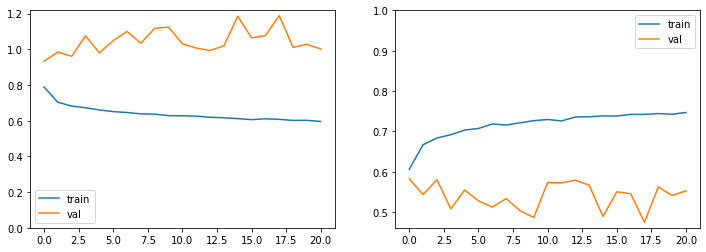

In [5]:
mrk_files = load.mrk_files_from_folder('data/augmentation/2-blurred/')
img_files = [mrk.file_path.replace('.mrk', '.png') for mrk in mrk_files]

x = load.images_from_list_files(img_files)
y = np.array([mrk.photo_reqs.blurred.value for mrk in mrk_files])

print(x.shape, x.dtype)
print(y.shape, y.dtype)

train_model(encoder, x, y, 'blurred')

# 3. Looking Away

9000 of 9000
9000 of 9000
(9000, 224, 224, 3) float32
(9000,) int32
[0 1 2] [3000 3000 3000]
Train on 8100 samples, validate on 900 samples
Epoch 1/50
8100/8100 [==============================] - 6s 775us/step - loss: 0.8684 - acc: 0.5510 - val_loss: 0.8079 - val_acc: 0.6144

Epoch 00001: val_acc improved from -inf to 0.61444, saving model to models/looking_away_2019_08_09-18_09_10.hdf5
Epoch 2/50
8100/8100 [==============================] - 6s 726us/step - loss: 0.7926 - acc: 0.6320 - val_loss: 0.7825 - val_acc: 0.6133

Epoch 00002: val_acc did not improve from 0.61444
Epoch 3/50
8100/8100 [==============================] - 6s 739us/step - loss: 0.7754 - acc: 0.6349 - val_loss: 0.7871 - val_acc: 0.6156

Epoch 00003: val_acc improved from 0.61444 to 0.61556, saving model to models/looking_away_2019_08_09-18_09_10.hdf5
Epoch 4/50
8100/8100 [==============================] - 6s 721us/step - loss: 0.7642 - acc: 0.6409 - val_loss: 0.8148 - val_acc: 0.5856

Epoch 00004: val_acc did not impr

(<keras.engine.training.Model at 0x1d4a07744e0>, LabelEncoder())

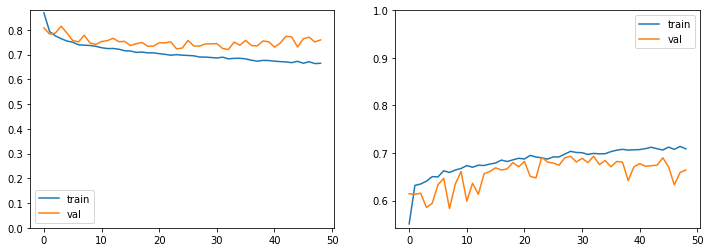

In [6]:
mrk_files = load.mrk_files_from_folder('data/augmentation/3-looking_away/')
img_files = [mrk.file_path.replace('.mrk', '.png') for mrk in mrk_files]

x = load.images_from_list_files(img_files)
y = np.array([mrk.photo_reqs.looking_away.value for mrk in mrk_files])

print(x.shape, x.dtype)
print(y.shape, y.dtype)

train_model(encoder, x, y, 'looking_away')

# ~~4. Ink Marked/Creased~~

# 5. Unnatural Skin Tone 

9000 of 9000
9000 of 9000
(9000, 224, 224, 3) float32
(9000,) int32
[0 1 2] [3000 3000 3000]
Train on 8100 samples, validate on 900 samples
Epoch 1/50
8100/8100 [==============================] - 8s 946us/step - loss: 0.9195 - acc: 0.5719 - val_loss: 0.9639 - val_acc: 0.5144

Epoch 00001: val_acc improved from -inf to 0.51444, saving model to models/unnatural_skin_tone_2019_08_09-18_19_33.hdf5
Epoch 2/50
8100/8100 [==============================] - 6s 724us/step - loss: 0.7752 - acc: 0.6467 - val_loss: 1.0784 - val_acc: 0.5200

Epoch 00002: val_acc improved from 0.51444 to 0.52000, saving model to models/unnatural_skin_tone_2019_08_09-18_19_33.hdf5
Epoch 3/50
8100/8100 [==============================] - 6s 721us/step - loss: 0.7297 - acc: 0.6635 - val_loss: 1.0961 - val_acc: 0.5444

Epoch 00003: val_acc improved from 0.52000 to 0.54444, saving model to models/unnatural_skin_tone_2019_08_09-18_19_33.hdf5
Epoch 4/50
8100/8100 [==============================] - 6s 719us/step - loss: 0.703

(<keras.engine.training.Model at 0x2b933068cf8>, LabelEncoder())

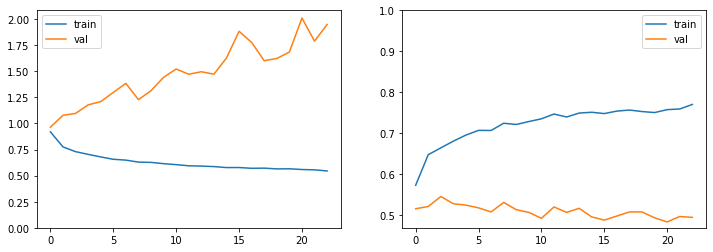

In [5]:
mrk_files = load.mrk_files_from_folder('data/augmentation/5-unnatural_skin_tone/')
img_files = [mrk.file_path.replace('.mrk', '.png') for mrk in mrk_files]

x = load.images_from_list_files(img_files)
y = np.array([mrk.photo_reqs.unnatural_skin_tone.value for mrk in mrk_files])

print(x.shape, x.dtype)
print(y.shape, y.dtype)

train_model(encoder, x, y, 'unnatural_skin_tone')

# 6. Too Dark/Light 

9000 of 9000
9000 of 9000
(9000, 224, 224, 3) float32
(9000,) int32
[0 1 2] [3000 3000 3000]
Train on 8100 samples, validate on 900 samples
Epoch 1/50
8100/8100 [==============================] - 6s 767us/step - loss: 0.6862 - acc: 0.7658 - val_loss: 0.8075 - val_acc: 0.6622

Epoch 00001: val_acc improved from -inf to 0.66222, saving model to models/too_dark_light_2019_08_09-18_25_28.hdf5
Epoch 2/50
8100/8100 [==============================] - 6s 716us/step - loss: 0.5359 - acc: 0.8259 - val_loss: 0.8561 - val_acc: 0.6667

Epoch 00002: val_acc improved from 0.66222 to 0.66667, saving model to models/too_dark_light_2019_08_09-18_25_28.hdf5
Epoch 3/50
8100/8100 [==============================] - 6s 718us/step - loss: 0.4783 - acc: 0.8515 - val_loss: 1.0444 - val_acc: 0.6467

Epoch 00003: val_acc did not improve from 0.66667
Epoch 4/50
8100/8100 [==============================] - 6s 719us/step - loss: 0.4529 - acc: 0.8588 - val_loss: 1.0912 - val_acc: 0.6489

Epoch 00004: val_acc did not 

(<keras.engine.training.Model at 0x2b6a3a62400>, LabelEncoder())

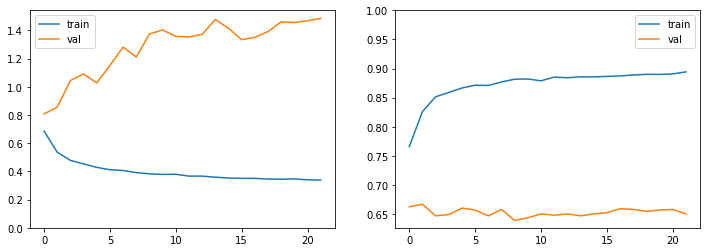

In [6]:
mrk_files = load.mrk_files_from_folder('data/augmentation/6-too_dark_light/')
img_files = [mrk.file_path.replace('.mrk', '.png') for mrk in mrk_files]

x = load.images_from_list_files(img_files)
y = np.array([mrk.photo_reqs.too_dark_light.value for mrk in mrk_files])

print(x.shape, x.dtype)
print(y.shape, y.dtype)

train_model(encoder, x, y, 'too_dark_light')

# 7. Washed Out

9000 of 9000
9000 of 9000
(9000, 224, 224, 3) float32
(9000,) int32
[0 1 2] [3000 3000 3000]
Train on 8100 samples, validate on 900 samples
Epoch 1/50
8100/8100 [==============================] - 6s 755us/step - loss: 0.4850 - acc: 0.8741 - val_loss: 0.3820 - val_acc: 0.8811

Epoch 00001: val_acc improved from -inf to 0.88111, saving model to models/washed_out_2019_08_09-18_30_29.hdf5
Epoch 2/50
8100/8100 [==============================] - 6s 702us/step - loss: 0.2271 - acc: 0.9537 - val_loss: 0.2780 - val_acc: 0.9144

Epoch 00002: val_acc improved from 0.88111 to 0.91444, saving model to models/washed_out_2019_08_09-18_30_29.hdf5
Epoch 3/50
8100/8100 [==============================] - 6s 700us/step - loss: 0.1820 - acc: 0.9578 - val_loss: 0.2820 - val_acc: 0.9100

Epoch 00003: val_acc did not improve from 0.91444
Epoch 4/50
8100/8100 [==============================] - 6s 702us/step - loss: 0.1588 - acc: 0.9615 - val_loss: 0.2798 - val_acc: 0.9100

Epoch 00004: val_acc did not improve 

8100/8100 [==============================] - 6s 703us/step - loss: 0.0320 - acc: 0.9933 - val_loss: 0.1080 - val_acc: 0.9678

Epoch 00040: val_acc did not improve from 0.96889
Epoch 41/50
8100/8100 [==============================] - 6s 700us/step - loss: 0.0311 - acc: 0.9919 - val_loss: 0.1022 - val_acc: 0.9700

Epoch 00041: val_acc improved from 0.96889 to 0.97000, saving model to models/washed_out_2019_08_09-18_30_29.hdf5
Epoch 42/50
8100/8100 [==============================] - 6s 702us/step - loss: 0.0322 - acc: 0.9912 - val_loss: 0.1151 - val_acc: 0.9667

Epoch 00042: val_acc did not improve from 0.97000
Epoch 43/50
8100/8100 [==============================] - 6s 702us/step - loss: 0.0299 - acc: 0.9937 - val_loss: 0.0896 - val_acc: 0.9744

Epoch 00043: val_acc improved from 0.97000 to 0.97444, saving model to models/washed_out_2019_08_09-18_30_29.hdf5
Epoch 44/50
8100/8100 [==============================] - 6s 702us/step - loss: 0.0316 - acc: 0.9923 - val_loss: 0.0914 - val_acc: 0.

(<keras.engine.training.Model at 0x2b6b4d5e400>, LabelEncoder())

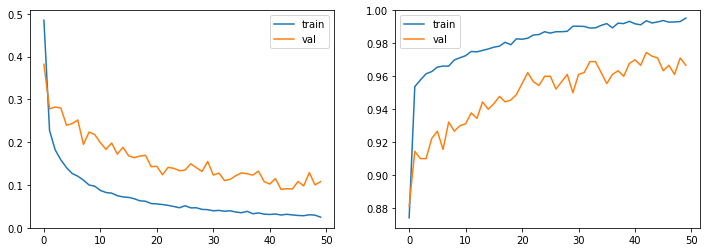

In [7]:
mrk_files = load.mrk_files_from_folder('data/augmentation/7-washed_out/')
img_files = [mrk.file_path.replace('.mrk', '.png') for mrk in mrk_files]

x = load.images_from_list_files(img_files)
y = np.array([mrk.photo_reqs.washed_out.value for mrk in mrk_files])

print(x.shape, x.dtype)
print(y.shape, y.dtype)

train_model(encoder, x, y, 'washed_out')

# *8. Pixelation*

913 of 6000

2620 of 6000

6000 of 6000
6000 of 6000
(6000, 224, 224, 3) float32
(6000,) int32
[0 1] [3000 3000]
Train on 5400 samples, validate on 600 samples
Epoch 1/50
5400/5400 [==============================] - 4s 800us/step - loss: 0.5120 - acc: 0.7422 - val_loss: 0.4740 - val_acc: 0.7917

Epoch 00001: val_acc improved from -inf to 0.79167, saving model to models/pixelation_2019_08_09-18_36_09.hdf5
Epoch 2/50
5400/5400 [==============================] - 4s 720us/step - loss: 0.4553 - acc: 0.7817 - val_loss: 0.4604 - val_acc: 0.7933

Epoch 00002: val_acc improved from 0.79167 to 0.79333, saving model to models/pixelation_2019_08_09-18_36_09.hdf5
Epoch 3/50
5400/5400 [==============================] - 4s 723us/step - loss: 0.4372 - acc: 0.8019 - val_loss: 0.4514 - val_acc: 0.7933

Epoch 00003: val_acc did not improve from 0.79333
Epoch 4/50
5400/5400 [==============================] - 4s 710us/step - loss: 0.4279 - acc: 0.8044 - val_loss: 0.4475 - val_acc: 0.8167

Epoch 00004: val_acc improved from 0.79333 t

(<keras.engine.training.Model at 0x2b9306744e0>, LabelEncoder())

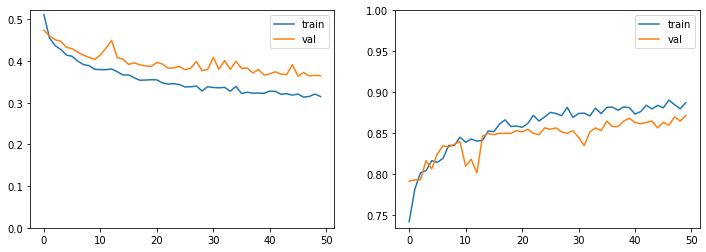

In [8]:
mrk_files = load.mrk_files_from_folder('data/augmentation/8-pixelation/')
img_files = [mrk.file_path.replace('.mrk', '.png') for mrk in mrk_files]

x = load.images_from_list_files(img_files)
y = np.array([mrk.photo_reqs.pixelation.value for mrk in mrk_files])

print(x.shape, x.dtype)
print(y.shape, y.dtype)

train_model(encoder, x, y, 'pixelation')

# 9. Hair Across Eyes 

9000 of 9000
9000 of 9000
(9000, 224, 224, 3) float32
(9000,) int32
[0 1 2] [3000 3000 3000]
Train on 8100 samples, validate on 900 samples
Epoch 1/50
8100/8100 [==============================] - 6s 760us/step - loss: 1.0646 - acc: 0.4259 - val_loss: 1.0456 - val_acc: 0.4200

Epoch 00001: val_acc improved from -inf to 0.42000, saving model to models/hair_across_eyes_2019_08_09-18_41_29.hdf5
Epoch 2/50
8100/8100 [==============================] - 6s 704us/step - loss: 1.0270 - acc: 0.4796 - val_loss: 1.0686 - val_acc: 0.4311

Epoch 00002: val_acc improved from 0.42000 to 0.43111, saving model to models/hair_across_eyes_2019_08_09-18_41_29.hdf5
Epoch 3/50
8100/8100 [==============================] - 6s 703us/step - loss: 1.0049 - acc: 0.5007 - val_loss: 1.0505 - val_acc: 0.4967

Epoch 00003: val_acc improved from 0.43111 to 0.49667, saving model to models/hair_across_eyes_2019_08_09-18_41_29.hdf5
Epoch 4/50
8100/8100 [==============================] - 6s 702us/step - loss: 0.9897 - acc: 

8100/8100 [==============================] - 6s 699us/step - loss: 0.8512 - acc: 0.6117 - val_loss: 1.0486 - val_acc: 0.4978

Epoch 00041: val_acc did not improve from 0.57889
Epoch 42/50
8100/8100 [==============================] - 6s 700us/step - loss: 0.8497 - acc: 0.6093 - val_loss: 1.0654 - val_acc: 0.5278

Epoch 00042: val_acc did not improve from 0.57889
Epoch 43/50
8100/8100 [==============================] - 6s 701us/step - loss: 0.8435 - acc: 0.6172 - val_loss: 1.0301 - val_acc: 0.5744

Epoch 00043: val_acc did not improve from 0.57889
Epoch 44/50
8100/8100 [==============================] - 6s 700us/step - loss: 0.8431 - acc: 0.6101 - val_loss: 1.0435 - val_acc: 0.5400

Epoch 00044: val_acc did not improve from 0.57889
Epoch 45/50
8100/8100 [==============================] - 6s 699us/step - loss: 0.8424 - acc: 0.6137 - val_loss: 1.0395 - val_acc: 0.5278

Epoch 00045: val_acc did not improve from 0.57889
Epoch 46/50
8100/8100 [==============================] - 6s 721us/step -

(<keras.engine.training.Model at 0x2b6b4a75ba8>, LabelEncoder())

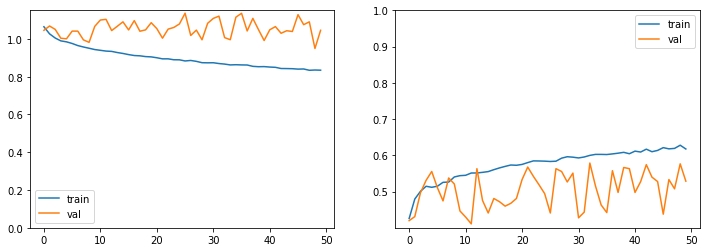

In [9]:
mrk_files = load.mrk_files_from_folder('data/augmentation/9-hair_across_eyes/')
img_files = [mrk.file_path.replace('.mrk', '.png') for mrk in mrk_files]

x = load.images_from_list_files(img_files)
y = np.array([mrk.photo_reqs.hair_across_eyes.value for mrk in mrk_files])

print(x.shape, x.dtype)
print(y.shape, y.dtype)

train_model(encoder, x, y, 'hair_across_eyes')

# 10. Eyes Closed  

9000 of 9000
9000 of 9000
(9000, 224, 224, 3) float32
(9000,) int32
[0 1 2] [3000 3000 3000]
Train on 8100 samples, validate on 900 samples
Epoch 1/50
8100/8100 [==============================] - 6s 769us/step - loss: 1.0598 - acc: 0.4500 - val_loss: 1.0484 - val_acc: 0.4378

Epoch 00001: val_acc improved from -inf to 0.43778, saving model to models/eyes_closed_2019_08_09-18_48_43.hdf5
Epoch 2/50
8100/8100 [==============================] - 6s 701us/step - loss: 1.0120 - acc: 0.5048 - val_loss: 1.0323 - val_acc: 0.4333

Epoch 00002: val_acc did not improve from 0.43778
Epoch 3/50
8100/8100 [==============================] - 6s 699us/step - loss: 0.9908 - acc: 0.5115 - val_loss: 1.0146 - val_acc: 0.4556

Epoch 00003: val_acc improved from 0.43778 to 0.45556, saving model to models/eyes_closed_2019_08_09-18_48_43.hdf5
Epoch 4/50
8100/8100 [==============================] - 6s 700us/step - loss: 0.9788 - acc: 0.5232 - val_loss: 1.0238 - val_acc: 0.4367

Epoch 00004: val_acc did not improv

8100/8100 [==============================] - 6s 701us/step - loss: 0.8595 - acc: 0.6094 - val_loss: 0.9537 - val_acc: 0.5389

Epoch 00040: val_acc did not improve from 0.54000
Epoch 41/50
8100/8100 [==============================] - 6s 704us/step - loss: 0.8541 - acc: 0.6156 - val_loss: 0.9581 - val_acc: 0.5256

Epoch 00041: val_acc did not improve from 0.54000
Epoch 42/50
8100/8100 [==============================] - 6s 703us/step - loss: 0.8543 - acc: 0.6119 - val_loss: 0.9466 - val_acc: 0.5400

Epoch 00042: val_acc did not improve from 0.54000
Epoch 43/50
8100/8100 [==============================] - 6s 703us/step - loss: 0.8541 - acc: 0.6147 - val_loss: 0.9626 - val_acc: 0.5122

Epoch 00043: val_acc did not improve from 0.54000
Epoch 44/50
8100/8100 [==============================] - 6s 701us/step - loss: 0.8525 - acc: 0.6144 - val_loss: 0.9461 - val_acc: 0.5133

Epoch 00044: val_acc did not improve from 0.54000
Epoch 45/50
8100/8100 [==============================] - 6s 701us/step -

(<keras.engine.training.Model at 0x2b9330c2320>, LabelEncoder())

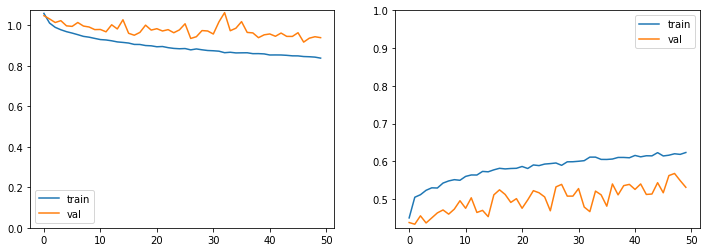

In [10]:
mrk_files = load.mrk_files_from_folder('data/augmentation/10-eyes_closed/')
img_files = [mrk.file_path.replace('.mrk', '.png') for mrk in mrk_files]

x = load.images_from_list_files(img_files)
y = np.array([mrk.photo_reqs.eyes_closed.value for mrk in mrk_files])

print(x.shape, x.dtype)
print(y.shape, y.dtype)

train_model(encoder, x, y, 'eyes_closed')

# 11. Varied Background

2684 of 9000

4457 of 9000

9000 of 9000
9000 of 9000
(9000, 224, 224, 3) float32
(9000,) int32
[0 1 2] [3000 3000 3000]
Train on 8100 samples, validate on 900 samples
Epoch 1/50
8100/8100 [==============================] - 6s 771us/step - loss: 0.8147 - acc: 0.6358 - val_loss: 0.7340 - val_acc: 0.6956

Epoch 00001: val_acc improved from -inf to 0.69556, saving model to models/varied_background_2019_08_09-18_57_13.hdf5
Epoch 2/50
8100/8100 [==============================] - 6s 705us/step - loss: 0.6895 - acc: 0.7130 - val_loss: 0.6445 - val_acc: 0.7289

Epoch 00002: val_acc improved from 0.69556 to 0.72889, saving model to models/varied_background_2019_08_09-18_57_13.hdf5
Epoch 3/50
8100/8100 [==============================] - 6s 706us/step - loss: 0.6477 - acc: 0.7274 - val_loss: 0.6391 - val_acc: 0.7278

Epoch 00003: val_acc did not improve from 0.72889
Epoch 4/50
8100/8100 [==============================] - 6s 707us/step - loss: 0.6299 - acc: 0.7348 - val_loss: 0.6106 - val_acc: 0.7411

Epoch 00004: val_acc im

8100/8100 [==============================] - 6s 707us/step - loss: 0.5312 - acc: 0.7688 - val_loss: 0.6104 - val_acc: 0.7578

Epoch 00041: val_acc did not improve from 0.76889
Epoch 42/50
8100/8100 [==============================] - 6s 710us/step - loss: 0.5321 - acc: 0.7658 - val_loss: 0.6458 - val_acc: 0.7500

Epoch 00042: val_acc did not improve from 0.76889
Epoch 43/50
8100/8100 [==============================] - 6s 709us/step - loss: 0.5272 - acc: 0.7688 - val_loss: 0.6242 - val_acc: 0.7278
Restoring model weights from the end of the best epoch

Epoch 00043: val_acc did not improve from 0.76889
Epoch 00043: early stopping
[[292   0   8]
 [ 65 233   2]
 [126   7 167]]
              precision    recall  f1-score   support

           0       0.60      0.97      0.75       300
           1       0.97      0.78      0.86       300
           2       0.94      0.56      0.70       300

    accuracy                           0.77       900
   macro avg       0.84      0.77      0.77    

(<keras.engine.training.Model at 0x2b9342f87f0>, LabelEncoder())

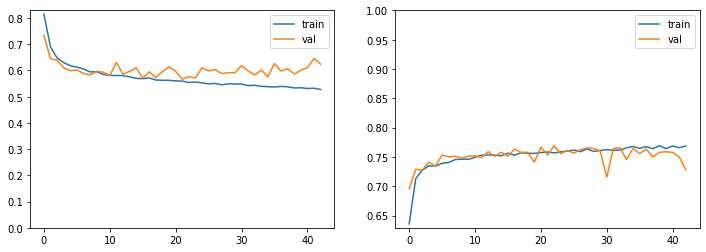

In [11]:
mrk_files = load.mrk_files_from_folder('data/augmentation/11-varied_bgd/')
img_files = [mrk.file_path.replace('.mrk', '.png') for mrk in mrk_files]

x = load.images_from_list_files(img_files)
y = np.array([mrk.photo_reqs.varied_background.value for mrk in mrk_files])

print(x.shape, x.dtype)
print(y.shape, y.dtype)

train_model(encoder, x, y, 'varied_background')

# 12. Roll/pitch/yaw

9000 of 9000
9000 of 9000
(9000, 224, 224, 3) float32
(9000,) int32
[0 1 2] [3000 3000 3000]
Train on 8100 samples, validate on 900 samples
Epoch 1/50
8100/8100 [==============================] - 6s 782us/step - loss: 0.9451 - acc: 0.5212 - val_loss: 0.8631 - val_acc: 0.5878

Epoch 00001: val_acc improved from -inf to 0.58778, saving model to models/roll_pitch_yaw_2019_08_09-19_05_15.hdf5
Epoch 2/50
8100/8100 [==============================] - 6s 720us/step - loss: 0.8629 - acc: 0.5679 - val_loss: 0.8452 - val_acc: 0.5678

Epoch 00002: val_acc did not improve from 0.58778
Epoch 3/50
8100/8100 [==============================] - 6s 713us/step - loss: 0.8357 - acc: 0.5802 - val_loss: 0.8394 - val_acc: 0.5811

Epoch 00003: val_acc did not improve from 0.58778
Epoch 4/50
8100/8100 [==============================] - 6s 721us/step - loss: 0.8180 - acc: 0.5907 - val_loss: 0.8015 - val_acc: 0.5933

Epoch 00004: val_acc improved from 0.58778 to 0.59333, saving model to models/roll_pitch_yaw_2019

8100/8100 [==============================] - 6s 715us/step - loss: 0.6886 - acc: 0.6637 - val_loss: 0.7774 - val_acc: 0.6111

Epoch 00041: val_acc did not improve from 0.63556
Epoch 42/50
8100/8100 [==============================] - 6s 715us/step - loss: 0.6882 - acc: 0.6620 - val_loss: 0.8238 - val_acc: 0.5878

Epoch 00042: val_acc did not improve from 0.63556
Epoch 43/50
8100/8100 [==============================] - 6s 715us/step - loss: 0.6833 - acc: 0.6619 - val_loss: 0.7841 - val_acc: 0.6133

Epoch 00043: val_acc did not improve from 0.63556
Epoch 44/50
8100/8100 [==============================] - 6s 716us/step - loss: 0.6841 - acc: 0.6654 - val_loss: 0.7649 - val_acc: 0.6267

Epoch 00044: val_acc did not improve from 0.63556
Epoch 45/50
8100/8100 [==============================] - 6s 719us/step - loss: 0.6860 - acc: 0.6675 - val_loss: 0.7722 - val_acc: 0.6133

Epoch 00045: val_acc did not improve from 0.63556
Epoch 46/50
8100/8100 [==============================] - 6s 719us/step -

(<keras.engine.training.Model at 0x2b93087c240>, LabelEncoder())

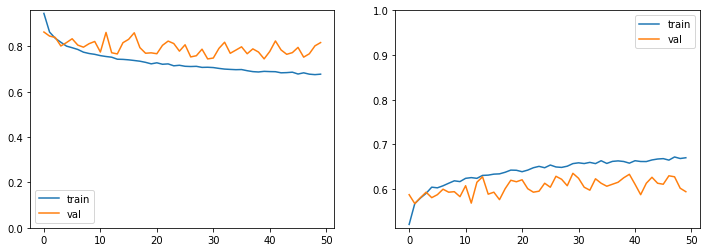

In [12]:
mrk_files = load.mrk_files_from_folder('data/augmentation/12-roll_pitch_yaw/')
img_files = [mrk.file_path.replace('.mrk', '.png') for mrk in mrk_files]

x = load.images_from_list_files(img_files)
y = np.array([mrk.photo_reqs.roll_pitch_yaw.value for mrk in mrk_files])

print(x.shape, x.dtype)
print(y.shape, y.dtype)

train_model(encoder, x, y, 'roll_pitch_yaw')

# 13. Flash Reflection on Skin

9000 of 9000
9000 of 9000
(9000, 224, 224, 3) float32
(9000,) int32
[0 1 2] [3000 3000 3000]
Train on 8100 samples, validate on 900 samples
Epoch 1/50
8100/8100 [==============================] - 8s 928us/step - loss: 0.9261 - acc: 0.5952 - val_loss: 0.9809 - val_acc: 0.5933

Epoch 00001: val_acc improved from -inf to 0.59333, saving model to models/flash_reflection_on_skin_2019_08_12-17_21_11.hdf5
Epoch 2/50
8100/8100 [==============================] - 6s 710us/step - loss: 0.8236 - acc: 0.6647 - val_loss: 0.9051 - val_acc: 0.6300

Epoch 00002: val_acc improved from 0.59333 to 0.63000, saving model to models/flash_reflection_on_skin_2019_08_12-17_21_11.hdf5
Epoch 3/50
8100/8100 [==============================] - 6s 711us/step - loss: 0.7969 - acc: 0.6753 - val_loss: 1.1430 - val_acc: 0.5544

Epoch 00003: val_acc did not improve from 0.63000
Epoch 4/50
8100/8100 [==============================] - 6s 706us/step - loss: 0.7762 - acc: 0.6895 - val_loss: 1.0644 - val_acc: 0.5989

Epoch 000

(<keras.engine.training.Model at 0x2ba3497c048>, LabelEncoder())

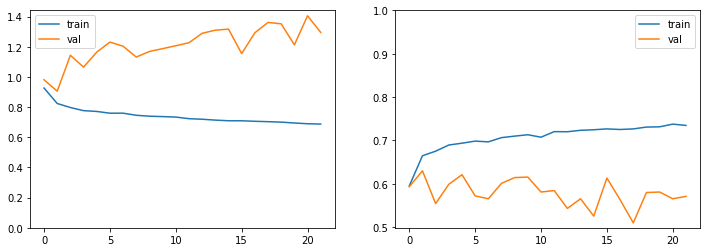

In [5]:
mrk_files = load.mrk_files_from_folder('data/augmentation/13-flash_reflection_on_skin/')
img_files = [mrk.file_path.replace('.mrk', '.png') for mrk in mrk_files]

x = load.images_from_list_files(img_files)
y = np.array([mrk.photo_reqs.flash_reflection_on_skin.value for mrk in mrk_files])

print(x.shape, x.dtype)
print(y.shape, y.dtype)

train_model(encoder, x, y, 'flash_reflection_on_skin')

# 14. Red Eyes 

9000 of 9000
9000 of 9000
(9000, 224, 224, 3) float32
(9000,) int32
[0 1 2] [3000 3000 3000]
Train on 8100 samples, validate on 900 samples
Epoch 1/50
8100/8100 [==============================] - 6s 764us/step - loss: 0.7000 - acc: 0.7040 - val_loss: 0.6035 - val_acc: 0.7144

Epoch 00001: val_acc improved from -inf to 0.71444, saving model to models/red_eyes_2019_08_12-17_26_35.hdf5
Epoch 2/50
8100/8100 [==============================] - 6s 706us/step - loss: 0.5719 - acc: 0.7535 - val_loss: 0.5923 - val_acc: 0.7133

Epoch 00002: val_acc did not improve from 0.71444
Epoch 3/50
8100/8100 [==============================] - 6s 709us/step - loss: 0.5342 - acc: 0.7628 - val_loss: 0.5245 - val_acc: 0.7478

Epoch 00003: val_acc improved from 0.71444 to 0.74778, saving model to models/red_eyes_2019_08_12-17_26_35.hdf5
Epoch 4/50
8100/8100 [==============================] - 6s 701us/step - loss: 0.5155 - acc: 0.7728 - val_loss: 0.5129 - val_acc: 0.7644

Epoch 00004: val_acc improved from 0.7477

(<keras.engine.training.Model at 0x2ba2d696d68>, LabelEncoder())

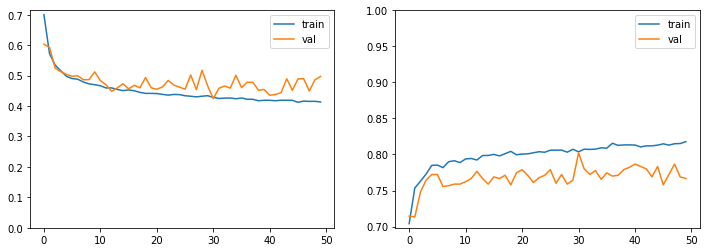

In [6]:
mrk_files = load.mrk_files_from_folder('data/augmentation/14-red_eyes/')
img_files = [mrk.file_path.replace('.mrk', '.png') for mrk in mrk_files]

x = load.images_from_list_files(img_files)
y = np.array([mrk.photo_reqs.red_eyes.value for mrk in mrk_files])

print(x.shape, x.dtype)
print(y.shape, y.dtype)

train_model(encoder, x, y, 'red_eyes')

# 15. Shadows Behind Head 

9000 of 9000
9000 of 9000
(9000, 224, 224, 3) float32
(9000,) int32
[0 1 2] [3000 3000 3000]
Train on 8100 samples, validate on 900 samples
Epoch 1/50
8100/8100 [==============================] - 6s 762us/step - loss: 0.4447 - acc: 0.8968 - val_loss: 0.3928 - val_acc: 0.8889

Epoch 00001: val_acc improved from -inf to 0.88889, saving model to models/shadows_behind_head_2019_08_12-17_34_27.hdf5
Epoch 2/50
8100/8100 [==============================] - 6s 720us/step - loss: 0.2260 - acc: 0.9443 - val_loss: 0.2945 - val_acc: 0.9033

Epoch 00002: val_acc improved from 0.88889 to 0.90333, saving model to models/shadows_behind_head_2019_08_12-17_34_27.hdf5
Epoch 3/50
8100/8100 [==============================] - 6s 724us/step - loss: 0.1675 - acc: 0.9565 - val_loss: 0.2940 - val_acc: 0.9000

Epoch 00003: val_acc did not improve from 0.90333
Epoch 4/50
8100/8100 [==============================] - 6s 697us/step - loss: 0.1363 - acc: 0.9660 - val_loss: 0.2528 - val_acc: 0.9111

Epoch 00004: val_ac

8100/8100 [==============================] - 6s 709us/step - loss: 0.0251 - acc: 0.9953 - val_loss: 0.1390 - val_acc: 0.9533

Epoch 00039: val_acc did not improve from 0.96000
Epoch 40/50
8100/8100 [==============================] - 6s 715us/step - loss: 0.0236 - acc: 0.9957 - val_loss: 0.1286 - val_acc: 0.9578

Epoch 00040: val_acc did not improve from 0.96000
Epoch 41/50
8100/8100 [==============================] - 6s 710us/step - loss: 0.0242 - acc: 0.9962 - val_loss: 0.1291 - val_acc: 0.9578

Epoch 00041: val_acc did not improve from 0.96000
Epoch 42/50
8100/8100 [==============================] - 6s 712us/step - loss: 0.0221 - acc: 0.9962 - val_loss: 0.1442 - val_acc: 0.9500

Epoch 00042: val_acc did not improve from 0.96000
Epoch 43/50
8100/8100 [==============================] - 6s 712us/step - loss: 0.0234 - acc: 0.9959 - val_loss: 0.1407 - val_acc: 0.9522 - loss: 0.0218 - acc: 0.9

Epoch 00043: val_acc did not improve from 0.96000
Epoch 44/50
8100/8100 [=======================

(<keras.engine.training.Model at 0x2bb79456208>, LabelEncoder())

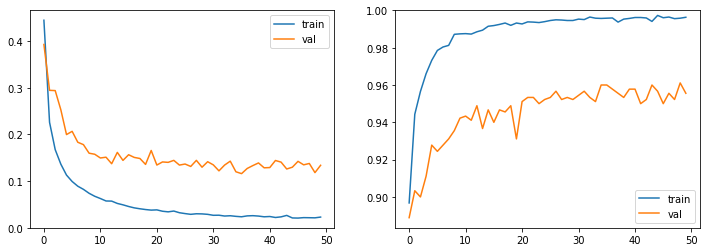

In [7]:
mrk_files = load.mrk_files_from_folder('data/augmentation/15-shadows_behind_head/')
img_files = [mrk.file_path.replace('.mrk', '.png') for mrk in mrk_files]

x = load.images_from_list_files(img_files)
y = np.array([mrk.photo_reqs.shadows_behind_head.value for mrk in mrk_files])

print(x.shape, x.dtype)
print(y.shape, y.dtype)

train_model(encoder, x, y, 'shadows_behind_head')

# 16. Shadows Across Face

9000 of 9000
9000 of 9000
(9000, 224, 224, 3) float32
(9000,) int32
[0 1 2] [3000 3000 3000]
Train on 8100 samples, validate on 900 samples
Epoch 1/50
8100/8100 [==============================] - 6s 775us/step - loss: 0.7383 - acc: 0.6475 - val_loss: 0.7342 - val_acc: 0.6511

Epoch 00001: val_acc improved from -inf to 0.65111, saving model to models/shadows_across_face_2019_08_12-17_41_32.hdf5
Epoch 2/50
8100/8100 [==============================] - 6s 725us/step - loss: 0.5924 - acc: 0.7269 - val_loss: 0.8053 - val_acc: 0.6511

Epoch 00002: val_acc did not improve from 0.65111
Epoch 3/50
8100/8100 [==============================] - 6s 719us/step - loss: 0.5704 - acc: 0.7402 - val_loss: 0.7689 - val_acc: 0.6578

Epoch 00003: val_acc improved from 0.65111 to 0.65778, saving model to models/shadows_across_face_2019_08_12-17_41_32.hdf5
Epoch 4/50
8100/8100 [==============================] - 6s 713us/step - loss: 0.5575 - acc: 0.7526 - val_loss: 0.7956 - val_acc: 0.6578

Epoch 00004: val_ac

(<keras.engine.training.Model at 0x2ba2df0c208>, LabelEncoder())

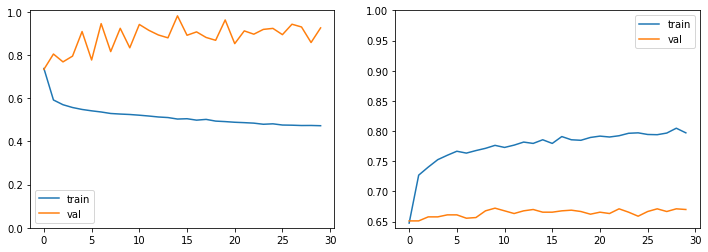

In [8]:
mrk_files = load.mrk_files_from_folder('data/augmentation/16-shadows_across_face/')
img_files = [mrk.file_path.replace('.mrk', '.png') for mrk in mrk_files]

x = load.images_from_list_files(img_files)
y = np.array([mrk.photo_reqs.shadows_across_face.value for mrk in mrk_files])

print(x.shape, x.dtype)
print(y.shape, y.dtype)

train_model(encoder, x, y, 'shadows_across_face')

# 17. Dark Tinted Lenses

9000 of 9000
9000 of 9000
(9000, 224, 224, 3) float32
(9000,) int32
[0 1 2] [3000 3000 3000]
Train on 8100 samples, validate on 900 samples
Epoch 1/50
8100/8100 [==============================] - 6s 764us/step - loss: 0.8516 - acc: 0.6627 - val_loss: 0.8851 - val_acc: 0.7433

Epoch 00001: val_acc improved from -inf to 0.74333, saving model to models/dark_tinted_lenses_2019_08_12-17_46_24.hdf5
Epoch 2/50
8100/8100 [==============================] - 6s 712us/step - loss: 0.7005 - acc: 0.7432 - val_loss: 0.9514 - val_acc: 0.6233

Epoch 00002: val_acc did not improve from 0.74333
Epoch 3/50
8100/8100 [==============================] - 6s 710us/step - loss: 0.6370 - acc: 0.7647 - val_loss: 0.8642 - val_acc: 0.6689

Epoch 00003: val_acc did not improve from 0.74333
Epoch 4/50
8100/8100 [==============================] - 6s 714us/step - loss: 0.5966 - acc: 0.7772 - val_loss: 0.9388 - val_acc: 0.6344

Epoch 00004: val_acc did not improve from 0.74333
Epoch 5/50
8100/8100 [=====================

(<keras.engine.training.Model at 0x2ba34cc00f0>, LabelEncoder())

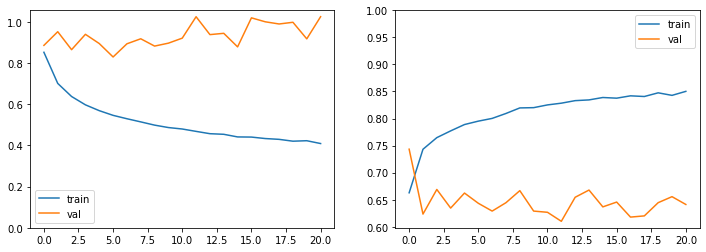

In [9]:
mrk_files = load.mrk_files_from_folder('data/augmentation/17-dark_tinted_lenses/')
img_files = [mrk.file_path.replace('.mrk', '.png') for mrk in mrk_files]

x = load.images_from_list_files(img_files)
y = np.array([mrk.photo_reqs.dark_tinted_lenses.value for mrk in mrk_files])

print(x.shape, x.dtype)
print(y.shape, y.dtype)

train_model(encoder, x, y, 'dark_tinted_lenses')

# 18. Flash Reflection on Lenses

9000 of 9000
9000 of 9000
(9000, 224, 224, 3) float32
(9000,) int32
[0 1 2] [3000 3000 3000]
Train on 8100 samples, validate on 900 samples
Epoch 1/50
8100/8100 [==============================] - 6s 768us/step - loss: 1.0245 - acc: 0.4630 - val_loss: 1.0281 - val_acc: 0.4933

Epoch 00001: val_acc improved from -inf to 0.49333, saving model to models/flash_reflection_on_lenses_2019_08_12-17_50_22.hdf5
Epoch 2/50
8100/8100 [==============================] - 6s 709us/step - loss: 0.9613 - acc: 0.5396 - val_loss: 0.9634 - val_acc: 0.5311

Epoch 00002: val_acc improved from 0.49333 to 0.53111, saving model to models/flash_reflection_on_lenses_2019_08_12-17_50_22.hdf5
Epoch 3/50
8100/8100 [==============================] - 6s 710us/step - loss: 0.9339 - acc: 0.5784 - val_loss: 0.9829 - val_acc: 0.5578

Epoch 00003: val_acc improved from 0.53111 to 0.55778, saving model to models/flash_reflection_on_lenses_2019_08_12-17_50_22.hdf5
Epoch 4/50
8100/8100 [==============================] - 6s 709

8100/8100 [==============================] - 6s 724us/step - loss: 0.7698 - acc: 0.6757 - val_loss: 0.9552 - val_acc: 0.5922

Epoch 00039: val_acc did not improve from 0.65556
Epoch 40/50
8100/8100 [==============================] - 6s 725us/step - loss: 0.7661 - acc: 0.6862 - val_loss: 0.9394 - val_acc: 0.6111

Epoch 00040: val_acc did not improve from 0.65556
Epoch 41/50
8100/8100 [==============================] - 6s 724us/step - loss: 0.7631 - acc: 0.6816 - val_loss: 0.9510 - val_acc: 0.5933

Epoch 00041: val_acc did not improve from 0.65556
Epoch 42/50
8100/8100 [==============================] - 6s 721us/step - loss: 0.7659 - acc: 0.6810 - val_loss: 0.9504 - val_acc: 0.6078

Epoch 00042: val_acc did not improve from 0.65556
Epoch 43/50
8100/8100 [==============================] - 6s 724us/step - loss: 0.7644 - acc: 0.6816 - val_loss: 1.0997 - val_acc: 0.5444

Epoch 00043: val_acc did not improve from 0.65556
Epoch 44/50
8100/8100 [==============================] - 6s 726us/step -

(<keras.engine.training.Model at 0x2ba34043630>, LabelEncoder())

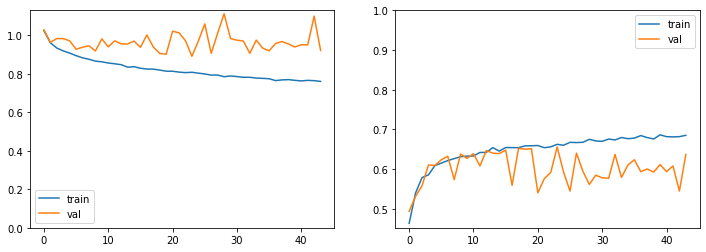

In [10]:
mrk_files = load.mrk_files_from_folder('data/augmentation/18-flash_reflection_on_lenses/')
img_files = [mrk.file_path.replace('.mrk', '.png') for mrk in mrk_files]

x = load.images_from_list_files(img_files)
y = np.array([mrk.photo_reqs.flash_reflection_on_lenses.value for mrk in mrk_files])

print(x.shape, x.dtype)
print(y.shape, y.dtype)

train_model(encoder, x, y, 'flash_reflection_on_lenses')

# ~~19. Frames Too Heavy~~

# 20. Frame Covering Eyes  

9000 of 9000
9000 of 9000
(9000, 224, 224, 3) float32
(9000,) int32
[0 1 2] [3000 3000 3000]
Train on 8100 samples, validate on 900 samples
Epoch 1/50
8100/8100 [==============================] - 6s 775us/step - loss: 0.8939 - acc: 0.5995 - val_loss: 0.8720 - val_acc: 0.6178

Epoch 00001: val_acc improved from -inf to 0.61778, saving model to models/frame_covering_eyes_2019_08_12-17_57_13.hdf5
Epoch 2/50
8100/8100 [==============================] - 6s 708us/step - loss: 0.8121 - acc: 0.6468 - val_loss: 0.8440 - val_acc: 0.6267

Epoch 00002: val_acc improved from 0.61778 to 0.62667, saving model to models/frame_covering_eyes_2019_08_12-17_57_13.hdf5
Epoch 3/50
8100/8100 [==============================] - 6s 706us/step - loss: 0.7911 - acc: 0.6565 - val_loss: 0.8192 - val_acc: 0.6422

Epoch 00003: val_acc improved from 0.62667 to 0.64222, saving model to models/frame_covering_eyes_2019_08_12-17_57_13.hdf5
Epoch 4/50
8100/8100 [==============================] - 6s 709us/step - loss: 0.776

8100/8100 [==============================] - 6s 712us/step - loss: 0.6484 - acc: 0.7220 - val_loss: 0.8397 - val_acc: 0.6533

Epoch 00041: val_acc did not improve from 0.67778
Epoch 42/50
8100/8100 [==============================] - 6s 718us/step - loss: 0.6457 - acc: 0.7263 - val_loss: 0.7529 - val_acc: 0.6733

Epoch 00042: val_acc did not improve from 0.67778
Epoch 43/50
8100/8100 [==============================] - 6s 710us/step - loss: 0.6466 - acc: 0.7275 - val_loss: 0.7514 - val_acc: 0.6678

Epoch 00043: val_acc did not improve from 0.67778
Epoch 44/50
8100/8100 [==============================] - 6s 710us/step - loss: 0.6400 - acc: 0.7290 - val_loss: 0.7202 - val_acc: 0.6711

Epoch 00044: val_acc did not improve from 0.67778
Epoch 45/50
8100/8100 [==============================] - 6s 712us/step - loss: 0.6395 - acc: 0.7317 - val_loss: 0.7417 - val_acc: 0.6678

Epoch 00045: val_acc did not improve from 0.67778
Epoch 46/50
8100/8100 [==============================] - 6s 712us/step -

(<keras.engine.training.Model at 0x2ba345a7dd8>, LabelEncoder())

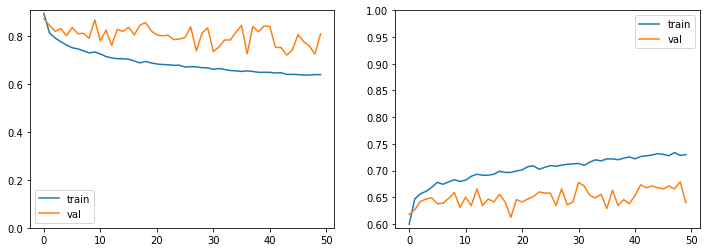

In [11]:
mrk_files = load.mrk_files_from_folder('data/augmentation/20-frame_covering_eyes/')
img_files = [mrk.file_path.replace('.mrk', '.png') for mrk in mrk_files]

x = load.images_from_list_files(img_files)
y = np.array([mrk.photo_reqs.frame_covering_eyes.value for mrk in mrk_files])

print(x.shape, x.dtype)
print(y.shape, y.dtype)

train_model(encoder, x, y, 'frame_covering_eyes')

# 21. Hat/cap 

9000 of 9000
9000 of 9000
(9000, 224, 224, 3) float32
(9000,) int32
[0 1 2] [3000 3000 3000]
Train on 8100 samples, validate on 900 samples
Epoch 1/50
8100/8100 [==============================] - 6s 773us/step - loss: 0.6991 - acc: 0.7264 - val_loss: 0.6436 - val_acc: 0.7544

Epoch 00001: val_acc improved from -inf to 0.75444, saving model to models/hat_cap_2019_08_12-18_04_31.hdf5
Epoch 2/50
8100/8100 [==============================] - 6s 711us/step - loss: 0.5677 - acc: 0.7957 - val_loss: 0.5934 - val_acc: 0.7733

Epoch 00002: val_acc improved from 0.75444 to 0.77333, saving model to models/hat_cap_2019_08_12-18_04_31.hdf5
Epoch 3/50
8100/8100 [==============================] - 6s 709us/step - loss: 0.5239 - acc: 0.8126 - val_loss: 0.5651 - val_acc: 0.7822

Epoch 00003: val_acc improved from 0.77333 to 0.78222, saving model to models/hat_cap_2019_08_12-18_04_31.hdf5
Epoch 4/50
8100/8100 [==============================] - 6s 709us/step - loss: 0.5011 - acc: 0.8198 - val_loss: 0.5388 -

(<keras.engine.training.Model at 0x2ba382d4d30>, LabelEncoder())

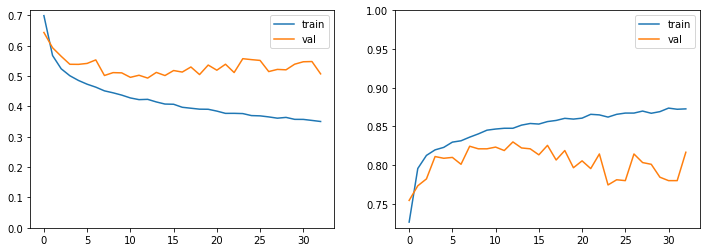

In [12]:
mrk_files = load.mrk_files_from_folder('data/augmentation/21-hat_cap/')
img_files = [mrk.file_path.replace('.mrk', '.png') for mrk in mrk_files]

x = load.images_from_list_files(img_files)
y = np.array([mrk.photo_reqs.hat_cap.value for mrk in mrk_files])

print(x.shape, x.dtype)
print(y.shape, y.dtype)

train_model(encoder, x, y, 'hat_cap')

# *22. Veil Over Face*

6000 of 6000
6000 of 6000
(6000, 224, 224, 3) float32
(6000,) int32
[0 1] [3000 3000]
Train on 5400 samples, validate on 600 samples
Epoch 1/50
5400/5400 [==============================] - 4s 812us/step - loss: 0.5369 - acc: 0.7452 - val_loss: 0.5805 - val_acc: 0.7683

Epoch 00001: val_acc improved from -inf to 0.76833, saving model to models/veil_over_face_2019_08_12-18_09_32.hdf5
Epoch 2/50
5400/5400 [==============================] - 4s 707us/step - loss: 0.4341 - acc: 0.8157 - val_loss: 0.4422 - val_acc: 0.8100

Epoch 00002: val_acc improved from 0.76833 to 0.81000, saving model to models/veil_over_face_2019_08_12-18_09_32.hdf5
Epoch 3/50
5400/5400 [==============================] - 4s 712us/step - loss: 0.3968 - acc: 0.8252 - val_loss: 0.4637 - val_acc: 0.8000

Epoch 00003: val_acc did not improve from 0.81000
Epoch 4/50
5400/5400 [==============================] - 4s 713us/step - loss: 0.3753 - acc: 0.8320 - val_loss: 0.4340 - val_acc: 0.8067

Epoch 00004: val_acc did not improve

(<keras.engine.training.Model at 0x2ba39843e48>, LabelEncoder())

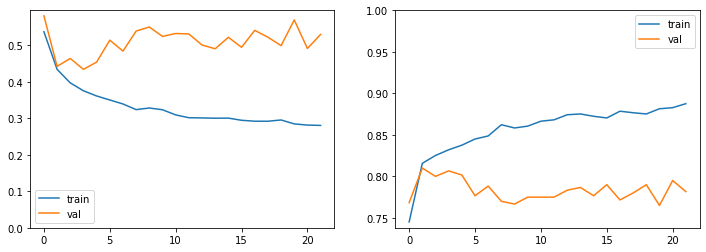

In [13]:
mrk_files = load.mrk_files_from_folder('data/augmentation/22-veil_over_face/')
img_files = [mrk.file_path.replace('.mrk', '.png') for mrk in mrk_files]

x = load.images_from_list_files(img_files)
y = np.array([mrk.photo_reqs.veil_over_face.value for mrk in mrk_files])

print(x.shape, x.dtype)
print(y.shape, y.dtype)

train_model(encoder, x, y, 'veil_over_face')

# 23. Mouth Open 

9000 of 9000
9000 of 9000
(9000, 224, 224, 3) float32
(9000,) int32
[0 1 2] [3000 3000 3000]
Train on 8100 samples, validate on 900 samples
Epoch 1/50
8100/8100 [==============================] - 6s 780us/step - loss: 1.0648 - acc: 0.4317 - val_loss: 1.0692 - val_acc: 0.4500

Epoch 00001: val_acc improved from -inf to 0.45000, saving model to models/mouth_open_2019_08_12-18_12_26.hdf5
Epoch 2/50
8100/8100 [==============================] - 6s 712us/step - loss: 1.0197 - acc: 0.4891 - val_loss: 1.0437 - val_acc: 0.4700

Epoch 00002: val_acc improved from 0.45000 to 0.47000, saving model to models/mouth_open_2019_08_12-18_12_26.hdf5
Epoch 3/50
8100/8100 [==============================] - 6s 716us/step - loss: 1.0033 - acc: 0.5030 - val_loss: 1.0453 - val_acc: 0.4667

Epoch 00003: val_acc did not improve from 0.47000
Epoch 4/50
8100/8100 [==============================] - 6s 713us/step - loss: 0.9983 - acc: 0.5106 - val_loss: 1.0526 - val_acc: 0.4744

Epoch 00004: val_acc improved from 0.

(<keras.engine.training.Model at 0x2ba3305ec50>, LabelEncoder())

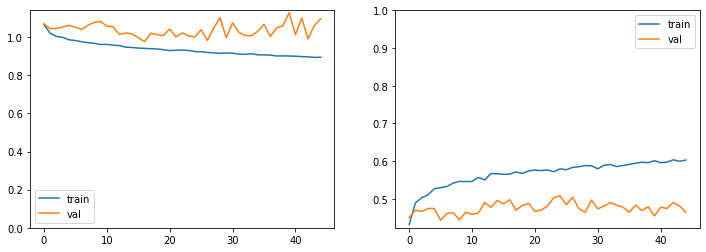

In [14]:
mrk_files = load.mrk_files_from_folder('data/augmentation/23-mouth_open/')
img_files = [mrk.file_path.replace('.mrk', '.png') for mrk in mrk_files]

x = load.images_from_list_files(img_files)
y = np.array([mrk.photo_reqs.mouth_open.value for mrk in mrk_files])

print(x.shape, x.dtype)
print(y.shape, y.dtype)

train_model(encoder, x, y, 'mouth_open')

# *24. Presence of Other Faces or Toys too Close to Face*

6000 of 6000
6000 of 6000
(6000, 224, 224, 3) float32
(6000,) int32
[0 1] [3000 3000]
Train on 5400 samples, validate on 600 samples
Epoch 1/50
5400/5400 [==============================] - 4s 811us/step - loss: 0.3766 - acc: 0.8563 - val_loss: 0.5093 - val_acc: 0.8033

Epoch 00001: val_acc improved from -inf to 0.80333, saving model to models/presence_of_other_faces_or_toys_2019_08_12-18_18_21.hdf5
Epoch 2/50
5400/5400 [==============================] - 4s 712us/step - loss: 0.2973 - acc: 0.8987 - val_loss: 0.5345 - val_acc: 0.8267

Epoch 00002: val_acc improved from 0.80333 to 0.82667, saving model to models/presence_of_other_faces_or_toys_2019_08_12-18_18_21.hdf5
Epoch 3/50
5400/5400 [==============================] - 4s 706us/step - loss: 0.2857 - acc: 0.8998 - val_loss: 0.5352 - val_acc: 0.8333

Epoch 00003: val_acc improved from 0.82667 to 0.83333, saving model to models/presence_of_other_faces_or_toys_2019_08_12-18_18_21.hdf5
Epoch 4/50
5400/5400 [==============================] 

(<keras.engine.training.Model at 0x2ba39994208>, LabelEncoder())

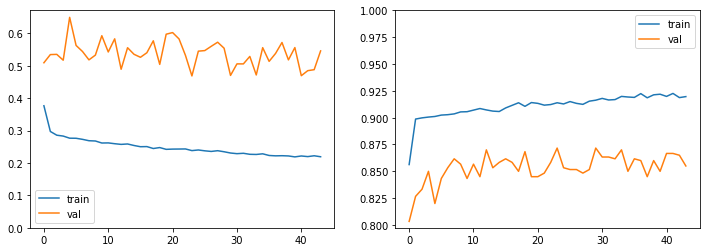

In [15]:
mrk_files = load.mrk_files_from_folder('data/augmentation/24-presence_of_other_faces_or_toys/')
img_files = [mrk.file_path.replace('.mrk', '.png') for mrk in mrk_files]

x = load.images_from_list_files(img_files)
y = np.array([mrk.photo_reqs.presence_of_other_faces_or_toys.value for mrk in mrk_files])

print(x.shape, x.dtype)
print(y.shape, y.dtype)

train_model(encoder, x, y, 'presence_of_other_faces_or_toys')

# Models Merge

In [4]:
file_models = [
    'models/blurred_2019_08_09-18_01_55.hdf5',
    'models/looking_away_2019_08_09-18_09_10.hdf5',
#     'models/',
    'models/unnatural_skin_tone_2019_08_09-18_19_33.hdf5',
    'models/too_dark_light_2019_08_09-18_25_28.hdf5',
    'models/washed_out_2019_08_09-18_30_29.hdf5',
    'models/pixelation_2019_08_09-18_36_09.hdf5',
    'models/hair_across_eyes_2019_08_09-18_41_29.hdf5',
    'models/eyes_closed_2019_08_09-18_48_43.hdf5',
    'models/varied_background_2019_08_09-18_57_13.hdf5',
    'models/roll_pitch_yaw_2019_08_09-19_05_15.hdf5',
    'models/flash_reflection_on_skin_2019_08_12-17_21_11.hdf5',
    'models/red_eyes_2019_08_12-17_26_35.hdf5',
    'models/shadows_behind_head_2019_08_12-17_34_27.hdf5',
    'models/shadows_across_face_2019_08_12-17_41_32.hdf5',
    'models/dark_tinted_lenses_2019_08_12-17_46_24.hdf5',
    'models/flash_reflection_on_lenses_2019_08_12-17_50_22.hdf5',
#     'models/',
    'models/frame_covering_eyes_2019_08_12-17_57_13.hdf5',
    'models/hat_cap_2019_08_12-18_04_31.hdf5',
    'models/veil_over_face_2019_08_12-18_09_32.hdf5',
    'models/mouth_open_2019_08_12-18_12_26.hdf5',
    'models/presence_of_other_faces_or_toys_2019_08_12-18_18_21.hdf5'
]

In [5]:
autoencoder = load_model('models/model_2019-6-17_12-29-19.hdf5')
embeddings = GlobalAvgPool2D(name='embeddings')(autoencoder.get_layer(name='encoded').output)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [6]:
list_models = [load_model(file) for file in file_models]
list_outputs = [model.get_layer(model.output_names[0])(embeddings) for model in list_models]

In [7]:
final_model = Model(inputs=autoencoder.inputs, outputs=list_outputs)
final_model.save('models/' + timestamp_model_name(prefix='final_model_'))
final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 224, 224, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 224, 224, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 224, 224, 16) 0           bn_1[0][0]                       
__________________________________________________________________________________________________
pool_1 (Ma

In [8]:
import cv2
from glob import glob

list_files = glob('data/val/FVC/images/*')
random_file = np.random.choice(list_files)

im = load.images_from_list_files([random_file], output_size=(224, 224), interpolation=cv2.INTER_AREA)
im /= 255

y_pred = final_model.predict(im)
list_predictions = [model.predict(im) for model in list_models]
assert(np.all([np.allclose(pred1, pred2) for pred1, pred2 in zip(y_pred, list_predictions)]))

1 of 1


# Error Analysis 

In [ ]:
y_val_dec = enc.inverse_transform(y_val)
y_pred_dec = enc.inverse_transform(y_pred)

cond = (y_val_dec == -1) & (y_pred_dec == 0)
im_errors = x_val[cond]
y_true = y_val_dec[cond]
print(im_errors.shape, y_true.shape)

plot.image_batch(im_errors[:, :, :, ::-1], y_true, n_cols=5, figsize=(16, 16))